# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

1. Read in the coupons.csv file.

In [239]:
car_sales = pd.read_csv('data/vehicles.csv')

In [240]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f


Dataframe for the model with the highest number of cars (f-150):
             id      region  price    year manufacturer  model  condition  \
228  7316384231  birmingham   5500  1978.0         ford  f-150       good   
235  7316307800  birmingham  27995  2017.0         ford  f-150        NaN   
249  7316163057  birmingham  37500  2018.0         ford  f-150        NaN   
337  7315354216  birmingham   8950  2011.0         ford  f-150  excellent   
537  7313642622  birmingham   3500  2006.0         ford  f-150        NaN   

       cylinders fuel  odometer title_status transmission                VIN  \
228  8 cylinders  gas  239000.0        clean    automatic                NaN   
235          NaN  gas  101000.0        clean    automatic                NaN   
249          NaN  gas   30026.0        clean    automatic  1FTEW1EP0JFD83808   
337  6 cylinders  gas  164000.0        clean    automatic  1FTMF1CM6BKD55331   
537          NaN  gas  246000.0        clean    automatic              

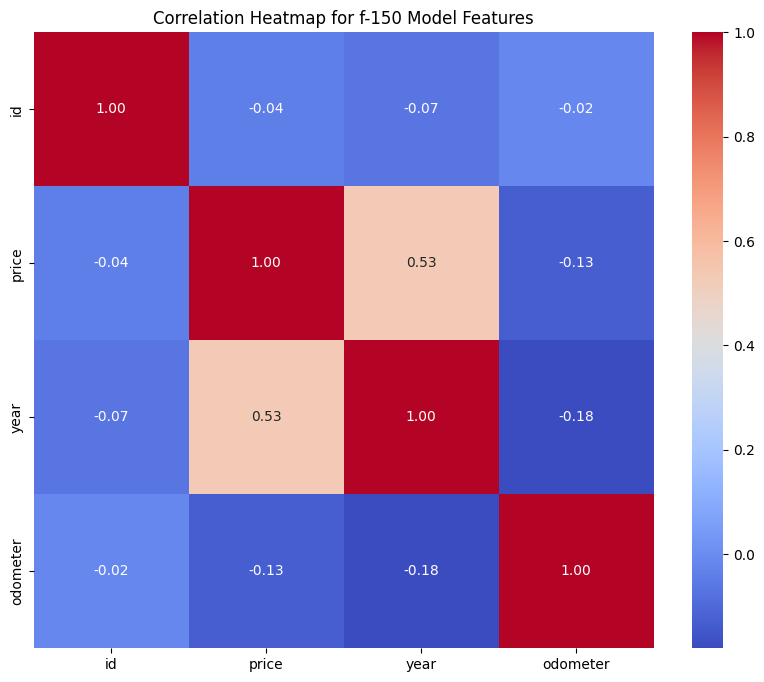

In [241]:
# Car model with highest number of cars and put it in a separate dataframe and create a correlation heatmap for the new dataframe

# Find the model with the highest number of cars
model_counts = car_sales['model'].value_counts()
most_common_model = model_counts.index[0]

# Create a new dataframe for the most common model
df_most_common_model = car_sales[car_sales['model'] == most_common_model].copy()

print(f"\nDataframe for the model with the highest number of cars ({most_common_model}):")
print(df_most_common_model.head())
#print(df_most_common_model.corr())

# Select only the numerical columns for correlation analysis
numerical_cols = df_most_common_model.select_dtypes(include=np.number).columns
df_numerical = df_most_common_model[numerical_cols]

# Calculate the correlation matrix for the numerical columns of the new dataframe
correlation_matrix_most_common_model = df_numerical.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_most_common_model, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for {most_common_model} Model Features')
plt.show()

There is some correlation between price and year but overall not very strong signals. We will repeat this after data clening.

In [242]:
car_sales.drop(['id','VIN','paint_color'], axis=1, inplace=True)

Investigate the dataset for missing or problematic data.

In [243]:
# Check for missing values
print(car_sales.isnull().sum().sort_values())

region               0
price                0
state                0
year              1205
transmission      2556
fuel              3013
odometer          4400
model             5277
title_status      8242
manufacturer     17646
type             92858
drive           130567
condition       174104
cylinders       177678
size            306361
dtype: int64


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

Drop irrelevant columns

In [244]:
# Replace NaN values in  some columns with "not_given"

car_sales['type'] = car_sales['type'].fillna('not_given')
car_sales['size'] = car_sales['size'].fillna('not_given')
car_sales['manufacturer'] = car_sales['manufacturer'].fillna('not_given')
car_sales['condition'] = car_sales['condition'].fillna('not_given')
car_sales['cylinders'] = car_sales['cylinders'].fillna('not_given')
car_sales['drive'] = car_sales['drive'].fillna('not_given')
car_sales['model'] = car_sales['model'].fillna('not_given')

In [246]:
# How many rows do I have in car_sales

print(len(car_sales))

426880


In [247]:
# Drop rows with NaN values for the remaining columns

car_sales.dropna(inplace=True)
print(car_sales.isnull().sum().sort_values())

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
state           0
dtype: int64


In [235]:
# Remaining data in car_sales

print(len(car_sales))

410742


In [249]:
# Sort the DataFrame by 'price' in descending order and select the top 20
car_sales.sort_values(by='price', ascending=False).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
318592,eugene,3736928711,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,4wd,full-size,pickup,or
356716,knoxville,3736928711,1999.0,toyota,4runner,fair,6 cylinders,gas,211000.0,clean,automatic,4wd,mid-size,not_given,tn
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,de
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nj
37410,modesto,3009548743,2021.0,chevrolet,not_given,not_given,8 cylinders,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
184704,frederick,1410065407,1989.0,jeep,wrangler,not_given,not_given,diesel,103000.0,clean,manual,not_given,not_given,SUV,md
153082,indianapolis,1234567890,2006.0,volvo,vnl,fair,not_given,other,200000.0,clean,manual,not_given,not_given,not_given,in
29386,humboldt county,1111111111,1999.0,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0,clean,automatic,rwd,full-size,pickup,ca
37409,modesto,1111111111,2020.0,jeep,not_given,not_given,not_given,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
122470,atlanta,987654321,1960.0,chevrolet,not_given,not_given,not_given,gas,9999999.0,clean,manual,not_given,not_given,not_given,ga


In [250]:
# Drop rows inplace with price value which are exceptionally high like $300+ million or made up like "1234567890".

prices_to_drop = [135008900, 25003000, 17000000, 2000000, 99999999, 3226714, 987654321, 12345678, 123456789, 3736928711, 1234567, 1234567890, 1111111111, 1111111]

# Drop rows where 'price' is in the list of prices to drop
car_sales.drop(car_sales[car_sales['price'].isin(prices_to_drop)].index, inplace=True)

In [251]:
# Sort the DataFrame by 'price' in descending order and select the top 20
car_sales.sort_values(by='price', ascending=False).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
91576,delaware,3024942282,2000.0,mercedes-benz,benz e320,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,de
257840,south jersey,3024942282,2000.0,mercedes-benz,benz s430,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nj
37410,modesto,3009548743,2021.0,chevrolet,not_given,not_given,8 cylinders,gas,1000.0,clean,automatic,4wd,not_given,not_given,ca
184704,frederick,1410065407,1989.0,jeep,wrangler,not_given,not_given,diesel,103000.0,clean,manual,not_given,not_given,SUV,md
241404,raleigh / durham / CH,113456789,1980.0,bmw,not_given,not_given,not_given,gas,100000.0,clean,automatic,not_given,not_given,not_given,nc
353641,jackson,11111111,1966.0,chevrolet,c10,not_given,not_given,gas,111111.0,clean,automatic,not_given,not_given,not_given,tn
300308,mansfield,10004000,2002.0,ford,f350,not_given,not_given,other,215000.0,clean,other,not_given,not_given,not_given,oh
105843,orlando,6995495,2014.0,dodge,journey,not_given,4 cylinders,gas,135888.0,clean,automatic,fwd,not_given,SUV,fl
283906,new hampshire,5000000,2021.0,not_given,all,not_given,not_given,other,1.0,clean,other,not_given,not_given,not_given,nh
286156,north dakota,1666666,1902.0,not_given,Recycling,not_given,not_given,other,1111111.0,parts only,other,not_given,not_given,not_given,nd


In [252]:
# Sort the DataFrame by 'price' in ascending order and select the top 20
car_sales.sort_values(by='price', ascending=True).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
22351,bakersfield,0,2019.0,cadillac,xts,not_given,not_given,gas,66403.0,clean,automatic,fwd,full-size,sedan,ca
53244,sacramento,0,2013.0,kia,soul,excellent,not_given,gas,61000.0,clean,automatic,fwd,not_given,wagon,ca
53243,sacramento,0,2008.0,acura,tsx,excellent,not_given,gas,90000.0,clean,automatic,fwd,not_given,sedan,ca
53242,sacramento,0,2018.0,bmw,7 series,excellent,not_given,gas,30000.0,clean,automatic,4wd,not_given,sedan,ca
53241,sacramento,0,2008.0,honda,cr-v,excellent,not_given,gas,72000.0,clean,automatic,fwd,not_given,SUV,ca
53240,sacramento,0,2009.0,infiniti,g37 sedan,excellent,not_given,gas,108000.0,clean,automatic,rwd,not_given,sedan,ca
53239,sacramento,0,2016.0,not_given,Maserati Ghibli,excellent,not_given,gas,48000.0,clean,automatic,rwd,not_given,sedan,ca
53238,sacramento,0,2008.0,mercedes-benz,slk,excellent,not_given,gas,123000.0,clean,automatic,rwd,not_given,convertible,ca
53237,sacramento,0,2003.0,chevrolet,silverado 2500 long b,not_given,8 cylinders,diesel,231256.0,clean,automatic,4wd,not_given,truck,ca
53236,sacramento,0,2008.0,bmw,x5,excellent,not_given,gas,0.0,clean,automatic,4wd,not_given,SUV,ca


In [253]:
# Count of cars with less than $2000 price and drop those rows, as the car dealers may not be interested in such cars

# Count of cars with price less than 2000
num_cars_low_price = car_sales[car_sales['price'] < 2000].shape[0]
print(f"Number of cars with price less than $2000: {num_cars_low_price}")

# Drop rows where the price is less than 2000
car_sales.drop(car_sales[car_sales['price'] < 2000].index, inplace=True)

# Verify the rows with price less than 2000 have been dropped
num_cars_low_price_after_drop = car_sales[car_sales['price'] < 2000].shape[0]
print(f"Number of cars with price less than $2000 after dropping: {num_cars_low_price_after_drop}")

Number of cars with price less than $2000: 49020
Number of cars with price less than $2000 after dropping: 0


In [254]:
# Sort the DataFrame by 'price' in ascending order and select the top 20
car_sales.sort_values(by='price', ascending=True).head(20)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
171233,lexington,2000,1993.0,mercury,capri,good,4 cylinders,gas,143000.0,clean,manual,fwd,compact,convertible,ky
335021,philadelphia,2000,2008.0,subaru,impreza,not_given,not_given,gas,150000.0,clean,automatic,not_given,not_given,sedan,pa
410686,spokane / coeur d'alene,2000,1978.0,chevrolet,luv,fair,4 cylinders,gas,50000.0,clean,manual,4wd,not_given,truck,wa
267885,buffalo,2000,2012.0,chevrolet,tahoe,not_given,not_given,gas,150000.0,salvage,automatic,not_given,not_given,not_given,ny
379525,odessa / midland,2000,2005.0,ford,expedition eddie bauer,good,8 cylinders,gas,190000.0,clean,automatic,rwd,not_given,not_given,tx
143304,peoria,2000,1981.0,chevrolet,not_given,not_given,not_given,gas,100000.0,clean,manual,not_given,not_given,pickup,il
89973,"washington, DC",2000,2008.0,honda,accord,not_given,not_given,gas,111111.0,clean,automatic,not_given,not_given,not_given,dc
376186,houston,2000,2014.0,chevrolet,silverado,not_given,not_given,gas,105000.0,clean,automatic,not_given,not_given,not_given,tx
376183,houston,2000,2007.0,toyota,camry,good,4 cylinders,gas,200000.0,salvage,automatic,fwd,full-size,sedan,tx
235380,eastern NC,2000,2004.0,ford,f-150,good,8 cylinders,gas,233786.0,clean,automatic,rwd,full-size,truck,nc


In [255]:
# Sort based on odometer value descending order

car_sales.sort_values(by='odometer', ascending=False).head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,state
413267,yakima,5500,1958.0,chevrolet,silverado,not_given,not_given,gas,10000000.0,clean,manual,not_given,not_given,not_given,wa
386655,st george,7000,1967.0,not_given,1967,fair,4 cylinders,gas,10000000.0,clean,manual,rwd,not_given,not_given,ut
149788,western IL,5000,1959.0,chevrolet,impala,not_given,not_given,gas,10000000.0,clean,manual,not_given,not_given,not_given,il
386654,st george,15000,1957.0,chevrolet,nomad,not_given,not_given,gas,10000000.0,rebuilt,automatic,not_given,not_given,not_given,ut
260971,albuquerque,4000,1973.0,jeep,cj5,good,8 cylinders,gas,10000000.0,clean,manual,4wd,not_given,offroad,nm


In [256]:
# Find the number of cars with more than 300000 odometer value and delete those rows.
# Car delars may not be interested in cars with such high reading

# Count the number of cars with odometer value more than 300000
num_cars_high_odometer = car_sales[car_sales['odometer'] > 300000].shape[0]
print(f"Number of cars with odometer value more than 300000: {num_cars_high_odometer}")

# Drop rows where the odometer value is more than 300000
car_sales.drop(car_sales[car_sales['odometer'] > 300000].index, inplace=True)

# Verify the rows with high odometer value have been dropped
num_cars_high_odometer_after_drop = car_sales[car_sales['odometer'] > 300000].shape[0]
print(f"Number of cars with odometer value more than 300000 after dropping: {num_cars_high_odometer_after_drop}")

Number of cars with odometer value more than 300000: 2400
Number of cars with odometer value more than 300000 after dropping: 0


In [257]:
# Find the count of cars with less than 100 odometer rating and older than 2015.
# Delete such rows and these are not usual scenarios and may skew the price data

# Count of cars with less than 100 odometer rating and older than 2015
num_cars_low_odometer_old_year = car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].shape[0]
print(f"Number of cars with less than 100 odometer rating and older than 2015: {num_cars_low_odometer_old_year}")

# Drop rows where odometer rating is less than 100 and year is older than 2015
car_sales.drop(car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].index, inplace=True)

# Verify the rows have been dropped
num_cars_low_odometer_old_year_after_drop = car_sales[(car_sales['odometer'] < 100) & (car_sales['year'] < 2015)].shape[0]
print(f"Number of cars with less than 100 odometer rating and older than 2015 after dropping: {num_cars_low_odometer_old_year_after_drop}")


Number of cars with less than 100 odometer rating and older than 2015: 2029
Number of cars with less than 100 odometer rating and older than 2015 after dropping: 0


In [258]:
# Create a separate dataframe car_sales_premium and move all cars more expensive than 60000 to car_sales_premium. Drop those cars more expensive than 120000 from car-sales dataframe inplace. Print the count of both car types

car_sales_premium = car_sales[car_sales['price'] > 60000].copy()
car_sales.drop(car_sales[car_sales['price'] > 60000].index, inplace=True)

print(f"Count of regular cars: {len(car_sales)}")
print(f"Count of premium cars: {len(car_sales_premium)}")

Count of regular cars: 351549
Count of premium cars: 5701


In [259]:
# Create a separate dataframe car_sales_electric and move all electric cars to car_sales_electric.
# Drop those electric cars from car-sales dataframe
# Electric cars may have to be looked at separately due to many reasons (like older data is not available)

car_sales_electric = car_sales[car_sales['fuel'] == 'electric'].copy()
car_sales.drop(car_sales[car_sales['fuel'] == 'electric'].index, inplace=True)
car_sales.drop(car_sales[car_sales['manufacturer'] == 'tesla'].index, inplace=True)

print(f"Count of non-electric cars: {len(car_sales)}")
print(f"Count of electric cars: {len(car_sales_electric)}")


Count of non-electric cars: 349972
Count of electric cars: 1451


In [260]:
# List all unique car types in car_sales

print("Unique car types:")
print(car_sales['type'].unique())

Unique car types:
['pickup' 'truck' 'other' 'not_given' 'coupe' 'SUV' 'hatchback' 'mini-van'
 'sedan' 'offroad' 'bus' 'convertible' 'wagon' 'van']


In [261]:
# Remove certain car types from car_sales

car_types_to_remove = ['truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup']
car_sales = car_sales[~car_sales['type'].isin(car_types_to_remove)]

print("Unique car types after removing 'truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup':")
print(car_sales['type'].unique())
print(len(car_sales))

Unique car types after removing 'truck', 'other', 'not_given', 'offroad', 'bus', 'coupe', 'convertible', 'pickup':
['SUV' 'hatchback' 'mini-van' 'sedan' 'wagon' 'van']
169265


In [262]:
# Average price per manufacturer in car_sales dataframe

average_price_per_manufacturer = car_sales.groupby('manufacturer')['price'].mean().reset_index()
average_price_per_manufacturer['average_price_dollars'] = average_price_per_manufacturer['price'].apply(lambda x: f"${x:,.2f}")
print("Average Price per Manufacturer (in dollars):")
print(average_price_per_manufacturer[['manufacturer', 'average_price_dollars']].sort_values(by='manufacturer'))

Average Price per Manufacturer (in dollars):
       manufacturer average_price_dollars
0             acura            $20,025.14
1        alfa-romeo            $30,045.98
2      aston-martin            $52,000.00
3              audi            $24,649.63
4               bmw            $20,506.42
5             buick            $15,754.59
6          cadillac            $22,180.93
7         chevrolet            $12,880.69
8          chrysler            $12,345.76
9            datsun            $18,954.08
10            dodge            $14,995.94
11             fiat            $12,732.02
12             ford            $13,910.62
13              gmc            $17,871.04
14  harley-davidson            $11,998.33
15            honda            $12,272.34
16          hyundai            $12,423.34
17         infiniti            $21,078.08
18           jaguar            $25,990.78
19             jeep            $20,068.61
20              kia            $13,417.78
21       land rover            

In [263]:
# Remove some premium manufacturers due to high average price which can skew our results

car_sales = car_sales[~car_sales['manufacturer'].isin(['aston-martin', 'alfa-romeo', 'audi', 'bmw', 'cadillac'])]
print(len(car_sales))

152645


In [264]:
# Drop the cars before 2000

import matplotlib.pyplot as plt
car_sales.drop(car_sales[car_sales['year'] < 2000].index, inplace=True)

print(f"\nNumber of rows after dropping cars before 2000: {len(car_sales)}")


Number of rows after dropping cars before 2000: 148726


In [265]:
# Show average price for year 2010 to 2021 year for each fuel type and number of cars per fuel type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and fuel type, calculate the mean price and count
average_price_count = car_sales_filtered_years.groupby(['year', 'fuel']).agg(
    average_price=('price', 'mean'),
    count=('price', 'count')
).reset_index()

# Pivot the table to have years as index and fuel types as columns for average price and count
average_price_pivot = average_price_count.pivot_table(index='year', columns='fuel', values='average_price')
count_pivot = average_price_count.pivot_table(index='year', columns='fuel', values='count')

# Combine the pivoted tables side by side
# Add prefixes to distinguish average price and count columns
average_price_pivot.columns = [f'average_price_{col}' for col in average_price_pivot.columns]
count_pivot.columns = [f'count_{col}' for col in count_pivot.columns]

# Concatenate the two dataframes side by side
combined_stats = pd.concat([average_price_pivot, count_pivot], axis=1)

# Sort columns alphabetically for better organization
combined_stats = combined_stats.sort_index(axis=1)

print("Average Price and Count by Year (2010-2021) and Fuel Type:")
combined_stats

Average Price and Count by Year (2010-2021) and Fuel Type:


,average_price_diesel,average_price_gas,average_price_hybrid,average_price_other,count_diesel,count_gas,count_hybrid,count_other
year,,,,,,,,
2010.0,10475.000000,8640.713769,7959.751111,11227.106061,32.0,6362.0,225.0,132.0
2011.0,14073.412500,10068.235548,10025.910448,11980.958065,80.0,7196.0,134.0,310.0
2012.0,12509.569892,11060.045087,10616.967347,13593.236407,93.0,8650.0,245.0,423.0
2013.0,12881.124138,12836.957824,11592.978125,15985.393939,145.0,10954.0,320.0,561.0
2014.0,18381.728261,14341.654084,12933.885593,19760.675325,184.0,9855.0,236.0,847.0
2015.0,20769.003984,16760.163636,14332.017094,20481.063422,251.0,10285.0,234.0,678.0
2016.0,27437.966667,18015.615761,16845.560241,20384.929988,30.0,10215.0,166.0,857.0
2017.0,27424.139241,21856.465787,18415.156177,24733.196440,158.0,11443.0,429.0,1573.0
2018.0,30828.029412,24784.136339,25086.338068,26487.242525,102.0,10914.0,352.0,1806.0


In [266]:
# Keep only fuel type gas in car_sales and drop other fuel type cars in place.

print(f"Current number of cars in car_sales: {len(car_sales)}")

# Keep only 'gas' fuel type and drop other fuel types in place
car_sales.drop(car_sales[car_sales['fuel'] != 'gas'].index, inplace=True)

print(f"Remaining number of cars after keeping only 'gas' fuel type: {len(car_sales)}")

Current number of cars in car_sales: 148726
Remaining number of cars after keeping only 'gas' fuel type: 133559


In [267]:
# Show the average price from 2010 to 2021 for each transmission type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and transmission, calculate the mean price
average_price_transmission = car_sales_filtered_years.groupby(['year', 'transmission'])['price'].mean().reset_index()

# Pivot the table to have years as index and transmission types as columns for average price
average_price_transmission_pivot = average_price_transmission.pivot_table(index='year', columns='transmission', values='price')

print("Average Price by Year (2010-2021) and Transmission Type:")
average_price_transmission_pivot

Average Price by Year (2010-2021) and Transmission Type:


transmission,automatic,manual,other
year,,,
2010.0,8550.233971,8268.520505,13512.440299
2011.0,9980.417040,9390.447531,14822.135294
2012.0,10858.638516,11274.052632,15149.875000
2013.0,12269.733893,12178.984238,18682.414534
2014.0,14068.409304,13134.375000,19874.435946
2015.0,16458.353374,14386.327217,20266.682779
2016.0,17869.475958,17776.362857,18912.133288
2017.0,21182.548935,20622.149837,24524.504451
2018.0,24401.349929,27542.598174,25563.840773


In [268]:
# Show the average price from 2010 to 2021 for each drive type

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and drive type, calculate the mean price
average_price_drive = car_sales_filtered_years.groupby(['year', 'drive'])['price'].mean().reset_index()

# Pivot the table to have years as index and drive types as columns for average price
average_price_drive_pivot = average_price_drive.pivot_table(index='year', columns='drive', values='price')

print("Average Price by Year (2010-2021) and Drive Type:")
average_price_drive_pivot

Average Price by Year (2010-2021) and Drive Type:


drive,4wd,fwd,not_given,rwd
year,,,,
2010.0,10629.327559,7026.989684,8628.442953,11305.427332
2011.0,12045.469952,7959.791129,10119.773764,13721.432836
2012.0,13651.601438,8783.233838,10782.410658,15769.235543
2013.0,15732.059959,10328.299645,13187.306425,17963.190821
2014.0,17478.689279,11408.732434,14729.947799,19858.444149
2015.0,20583.602872,13298.756598,17170.173585,23149.322581
2016.0,22751.117738,14685.923459,18873.317899,24212.091281
2017.0,26385.609885,17511.414588,23645.548687,26960.830125
2018.0,29549.077792,20217.891413,27402.681338,29692.882850


rwd is most expensive followed by 4wd and then fwd

In [275]:
# Show average price for year 2010 to 2021 year for each title_status

# Filter data for the years 2010 to 2021
car_sales_filtered_years = car_sales[(car_sales['year'] >= 2010) & (car_sales['year'] <= 2021)]

# Group by year and title_status, calculate the mean price
average_price_title_status = car_sales_filtered_years.groupby(['year', 'title_status'])['price'].mean().reset_index()

# Pivot the table to have years as index and title_status as columns for average price
average_price_title_status_pivot = average_price_title_status.pivot_table(index='year', columns='title_status', values='price')

print("Average Price by Year (2010-2021) and Title Status:")
average_price_title_status_pivot

Average Price by Year (2010-2021) and Title Status:


title_status,clean,lien,missing,parts only,rebuilt,salvage
year,,,,,,
2010.0,8679.646943,9870.961538,2866.666667,NaN,7845.194969,6384.107143
2011.0,10124.691899,13186.962963,2000.000000,4000.0,7997.371212,7698.797101
2012.0,11145.170305,11274.000000,NaN,NaN,8880.450495,7826.576471
2013.0,12968.910791,12130.857143,NaN,9200.0,9510.358156,7951.071429
2014.0,14504.948562,15398.296296,NaN,NaN,10962.220930,10365.235849
2015.0,17016.867167,18237.290909,NaN,NaN,12070.656676,10822.006944
2016.0,18323.720489,16429.531250,3950.000000,NaN,12490.783163,11670.724771
2017.0,22175.002666,22807.682927,2850.000000,NaN,15577.813364,13629.144444
2018.0,25123.640321,23772.300000,NaN,8800.0,16526.107256,13754.250000


In some cases the price may vary a lot based on title_status, this shoud be part of the model

In [270]:
print(f"Remaining number of cars: {len(car_sales)}")

Remaining number of cars: 133559



Dataframe for the model with the highest number of cars (camry):
         region  price    year manufacturer  model  condition    cylinders  \
310  birmingham   4499  2005.0       toyota  camry  not_given  4 cylinders   
379  birmingham   4000  2002.0       toyota  camry   like new  4 cylinders   
469  birmingham  12499  2012.0       toyota  camry  not_given  4 cylinders   
472  birmingham   7999  2007.0       toyota  camry  not_given  6 cylinders   
647  birmingham   8500  2011.0       toyota  camry  excellent  4 cylinders   

    fuel  odometer title_status transmission drive       size   type state  
310  gas  170687.0        clean    automatic   fwd  not_given  sedan    al  
379  gas  160000.0        clean    automatic   fwd  full-size  sedan    al  
469  gas   64950.0        clean    automatic   fwd  not_given  sedan    al  
472  gas   67650.0        clean    automatic   fwd  not_given  sedan    al  
647  gas  114500.0        clean    automatic   fwd  full-size  sedan    al  


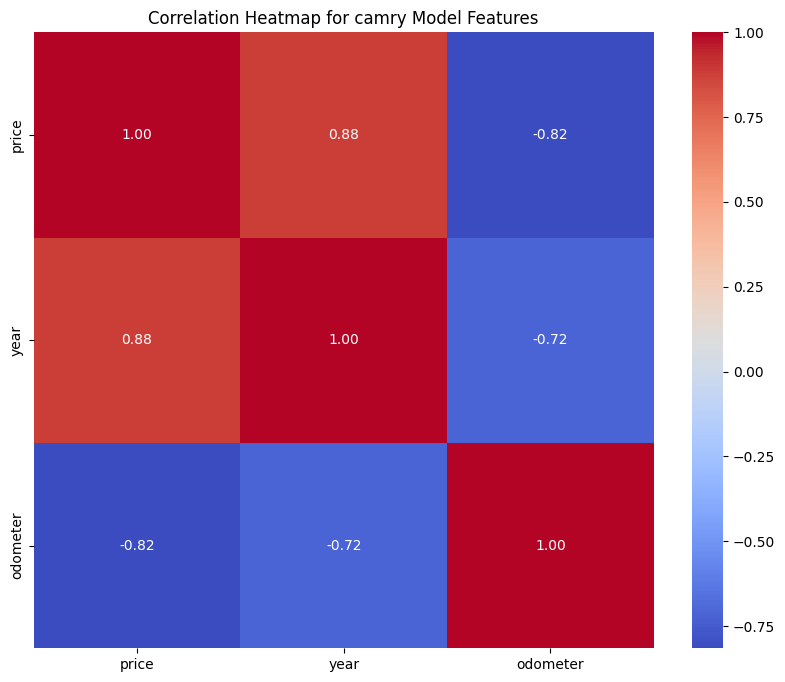

In [271]:
# Find a car model (like Toyota Camry) with highest number of cars and put it in a separate dataframe and create a correlation heatmap for the new dataframe

# Find the model with the highest number of cars
model_counts = car_sales['model'].value_counts()
most_common_model = model_counts.index[0]

# Create a new dataframe for the most common model
df_most_common_model = car_sales[car_sales['model'] == most_common_model].copy()

print(f"\nDataframe for the model with the highest number of cars ({most_common_model}):")
print(df_most_common_model.head())
#print(df_most_common_model.corr())

# Select only the numerical columns for correlation analysis
numerical_cols = df_most_common_model.select_dtypes(include=np.number).columns
df_numerical = df_most_common_model[numerical_cols]

# Calculate the correlation matrix for the numerical columns of the new dataframe
correlation_matrix_most_common_model = df_numerical.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_most_common_model, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Heatmap for {most_common_model} Model Features')
plt.show()

The heatmap now shows strong positive correlation between year and price. Also, it shows negative correlation between price and odometer  

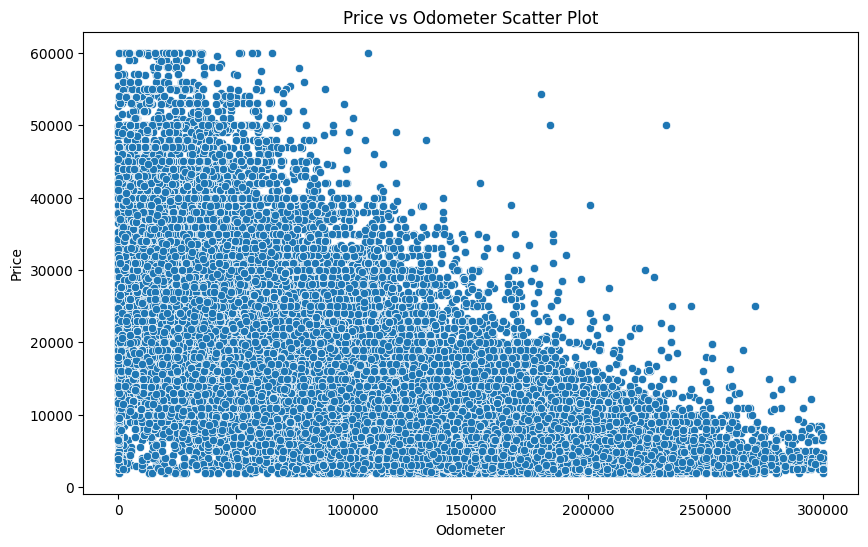

In [272]:
# Create a scatter plot for price and odometer

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='odometer', y='price', data=car_sales)


plt.title('Price vs Odometer Scatter Plot')
plt.xlabel('Odometer')
plt.ylabel('Price')
plt.show()

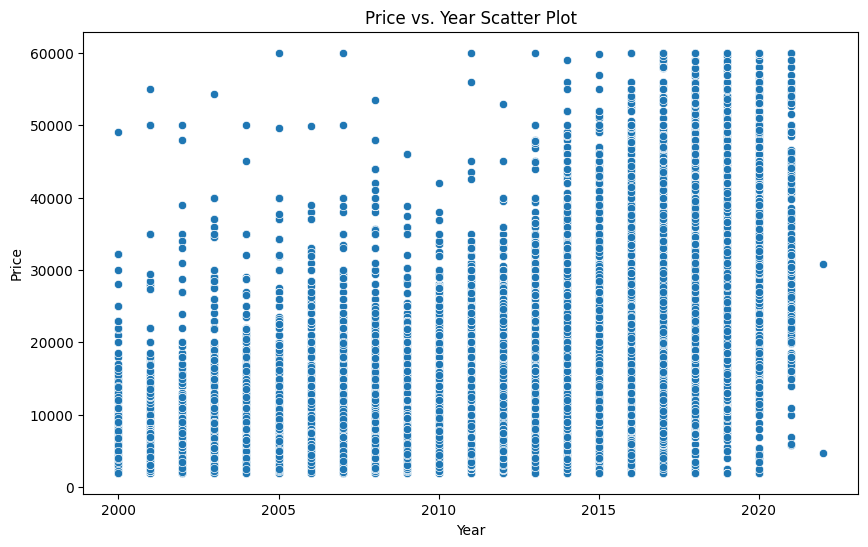

In [273]:
# Create a scatter plot for price and year

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=car_sales)
plt.title('Price vs. Year Scatter Plot')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

Count of Toyota Camry/Camery/Camry dataset: 2804


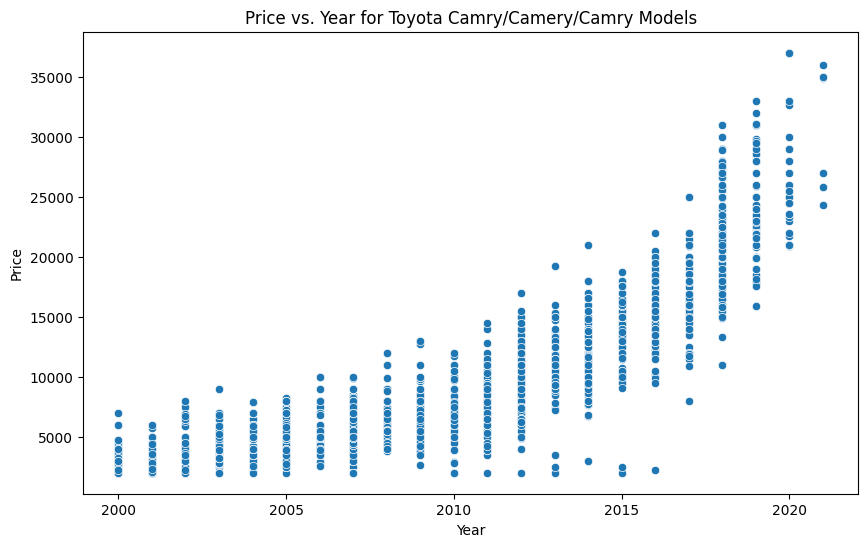

In [286]:
# Create a scatter plot for price and year where manufacturer is Toyota and model contains (camery, camary, camry).

import matplotlib.pyplot as plt
# Filter for Toyota and Camry/Camery/Camry models
toyota_camry_df = car_sales[
    (car_sales['manufacturer'] == 'toyota') &
    (car_sales['model'].str.contains('camry|camery|camry', case=False, na=False))
].copy()

# Print the count of this dataset
print(f"Count of Toyota Camry/Camery/Camry dataset: {len(toyota_camry_df)}")

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='price', data=toyota_camry_df)
plt.title('Price vs. Year for Toyota Camry/Camery/Camry Models')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

In [349]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133559 entries, 49 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        133559 non-null  object 
 1   price         133559 non-null  int64  
 2   year          133559 non-null  float64
 3   manufacturer  133559 non-null  object 
 4   model         133559 non-null  object 
 5   condition     133559 non-null  object 
 6   cylinders     133559 non-null  object 
 7   fuel          133559 non-null  object 
 8   odometer      133559 non-null  float64
 9   title_status  133559 non-null  object 
 10  transmission  133559 non-null  object 
 11  drive         133559 non-null  object 
 12  size          133559 non-null  object 
 13  type          133559 non-null  object 
 14  state         133559 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 20.3+ MB


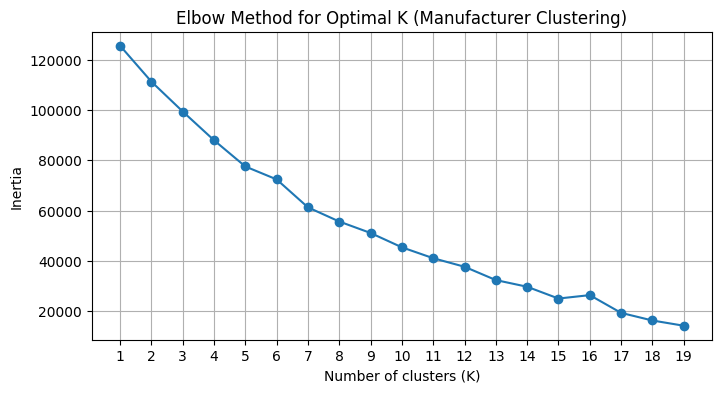


Distribution of Manufacturers within Clusters:
manufacturer_cluster  manufacturer   
0                     nissan              8704
                      jeep                8601
                      subaru              5852
                      hyundai             5498
                      dodge               5166
                      kia                 4656
                      lexus               4471
                      mercedes-benz       4456
                      volkswagen          4435
                      gmc                 3306
                      not_given           3266
                      chrysler            3007
                      acura               2912
                      buick               2686
                      mazda               2423
                      infiniti            2276
                      lincoln             2059
                      volvo               1870
                      mitsubishi          1260
                     

In [351]:
# prompt: Using k-means clustering group the data in car_sales based on manufacturer

import matplotlib.pyplot as plt
# Select the relevant column for clustering
manufacturers = car_sales[['manufacturer']].copy()

# Since KMeans works on numerical data, we can use one-hot encoding or
# simply treat each manufacturer as a separate point in a high-dimensional space
# based on counts, but that doesn't make sense for grouping by the manufacturer itself.
# A more appropriate use of clustering might be on other features to see
# if manufacturers naturally group together based on their car's characteristics.

# However, if the task is strictly to use KMeans to "group the data in car_sales based on manufacturer",
# and KMeans requires numerical data, we can encode the manufacturer column.
# Note: Clustering a categorical column like this directly might not yield meaningful
# insights about *characteristics* that define the groups, but it will group
# identical manufacturer names together.

# We can use one-hot encoding to represent manufacturers numerically
ct = ColumnTransformer(
    [('ohe', OneHotEncoder(handle_unknown='ignore'), ['manufacturer'])],
    remainder='passthrough'
)

manufacturers_encoded = ct.fit_transform(manufacturers)

# Determine the optimal number of clusters using the Elbow method
# We'll try a range of possible cluster numbers
inertia = []
k_range = range(1, min(20, manufacturers_encoded.shape[1] + 1)) # Limit k to a reasonable range

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Add n_init
    kmeans.fit(manufacturers_encoded)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Manufacturer Clustering)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# From the Elbow plot, choose a sensible number of clusters.
# Based on the plot for manufacturer clustering, the elbow is usually at a very low K,
# as the data is just categories. Let's choose k=5 as an example, or the point where the
# decrease in inertia starts to slow down significantly.
optimal_k = 5 # Choose based on the elbow plot

# Apply KMeans clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Add n_init
car_sales['manufacturer_cluster'] = kmeans.fit_predict(manufacturers_encoded)

# Analyze the clusters
print("\nDistribution of Manufacturers within Clusters:")
print(car_sales.groupby('manufacturer_cluster')['manufacturer'].value_counts())

# You can also look at which manufacturers are in each cluster
for cluster_id in range(optimal_k):
    manufacturers_in_cluster = car_sales[car_sales['manufacturer_cluster'] == cluster_id]['manufacturer'].unique()
    print(f"\nCluster {cluster_id}: {list(manufacturers_in_cluster)}")

# You can drop the added cluster column if not needed for subsequent steps
# car_sales.drop('manufacturer_cluster', axis=1, inplace=True)

In [ ]:
# prompt: create a dataframe car_sales_normalized with columns price, year, condition, fuel, odometer, title_status, size, type

#car_sales_normalized = car_sales[['price', 'year', 'condition', 'fuel', 'odometer', 'title_status', 'size', 'type']].copy()
#car_sales_normalized = car_sales[['price', 'year', 'odometer', 'title_status', 'size']].copy()
#car_sales_normalized.info()

In [ ]:
# Create a copy of car_sales called car_sales_all and later Drop all columns from car_sales except odometer, year and price

#car_sales_all = car_sales.copy()
#car_sales = car_sales[['odometer', 'year', 'price']]
#car_sales.info()

In [146]:
def svd_norm(X):
    x_norm =( X - X.mean())/X.std()
    U, sigma, VT = svd(x_norm, full_matrices=False)
    Sigma = np.diag(sigma)
    return U, Sigma, VT

In [ ]:
# Apply one hot encoding to the car_sales_normalized dataframe

#import pandas as pd
# Select categorical columns for one-hot encoding
#categorical_cols = ['condition', 'fuel', 'title_status', 'size', 'type']
#categorical_cols = ['title_status', 'size']

# Apply one-hot encoding
#car_sales_normalized = pd.get_dummies(car_sales_normalized, columns=categorical_cols)

#car_sales_normalized.info()

In [148]:
from scipy.linalg import svd
U, Sigma, VT = None, None, None

### BEGIN SOLUTION
U, Sigma, VT = svd_norm(car_sales)
### END SOLUTION

# Answer check
print(type(U))
print(car_sales.shape, Sigma.shape)
Sigma

<class 'numpy.ndarray'>
(224408, 3) (3, 3)


array([[649.64476342,   0.        ,   0.        ],
       [  0.        , 402.4461411 ,   0.        ],
       [  0.        ,   0.        , 298.69681094]])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [140]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148726 entries, 49 to 426878
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        148726 non-null  object 
 1   price         148726 non-null  int64  
 2   year          148726 non-null  float64
 3   manufacturer  148726 non-null  object 
 4   model         148726 non-null  object 
 5   condition     148726 non-null  object 
 6   cylinders     148726 non-null  object 
 7   fuel          148726 non-null  object 
 8   odometer      148726 non-null  float64
 9   title_status  148726 non-null  object 
 10  transmission  148726 non-null  object 
 11  drive         148726 non-null  object 
 12  size          148726 non-null  object 
 13  type          148726 non-null  object 
 14  state         148726 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 18.2+ MB


In [319]:
# Create different dataframes for building various models

car_sales_1 = car_sales[['price', 'odometer']].copy()
car_sales_2 = car_sales[['price', 'odometer', 'year']].copy()
car_sales_3 = car_sales[['price', 'odometer', 'year', 'title_status']].copy()
car_sales_4 = car_sales[['price', 'odometer', 'year', 'title_status', 'transmission']].copy()
car_sales_5 = car_sales[['price', 'odometer', 'year', 'title_status', 'transmission', 'fuel']].copy()


In [288]:
# First model, divide the data in car sales into train, test and dev

# Divide data into train, test, and dev sets
X = car_sales_1.drop('price', axis=1)
y = car_sales_1['price']

X = X - X.mean()
X = X / X.std()

y = y - y.mean()
y = y / y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Development set shape: {X_dev.shape}, {y_dev.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (80135, 1), (80135,)
Development set shape: (26712, 1), (26712,)
Test set shape: (26712, 1), (26712,)


Linear Regression Model Performance on Development Set (Predicting Price from Odometer):
Mean Squared Error (MSE): 0.56
Root Mean Squared Error (RMSE): 0.75


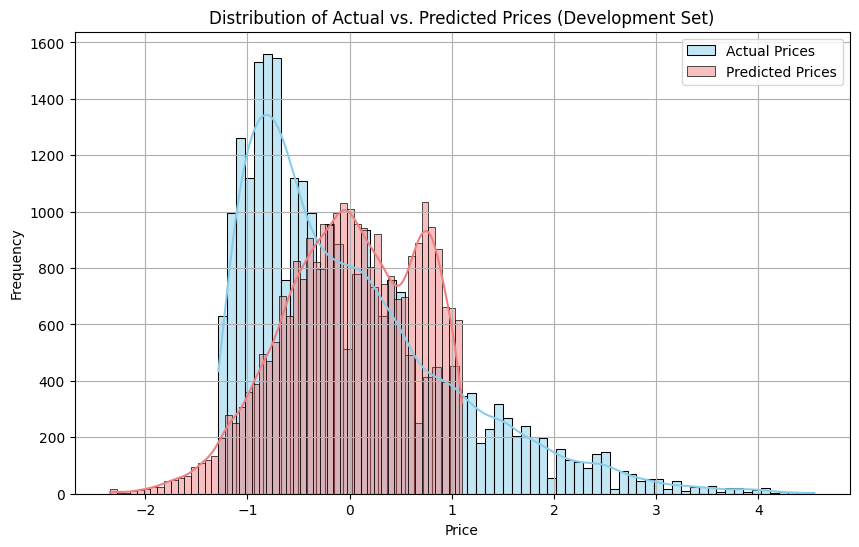

In [290]:
# First Model: Linear Regression model to predict the price from odometer

import matplotlib.pyplot as plt
import numpy as np
# Select features and target
features = ['odometer']
target = 'price'

X_train_odometer = X_train[features]
X_dev_odometer = X_dev[features]
X_test_odometer = X_test[features]

# Initialize and train the Linear Regression model
model_1 = LinearRegression()
model_1.fit(X_train_odometer, y_train)

# Evaluate the model on the development set
y_dev_pred = model_1.predict(X_dev_odometer)

mse = mean_squared_error(y_dev, y_dev_pred)
rmse = np.sqrt(mse)

print("Linear Regression Model Performance on Development Set (Predicting Price from Odometer):")

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs predicted values for model_1 on the development set
#plt.figure(figsize=(10, 6))
#plt.scatter(y_dev, y_dev_pred, alpha=0.5)
#plt.title('Model 1: Actual vs. Predicted Price (Development Set)')
#plt.xlabel('Actual Price')
#plt.ylabel('Predicted Price')
#plt.grid(True)
#plt.show()

# Plot histogram of predicted prices
plt.figure(figsize=(10, 6))
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)
sns.histplot(y_dev_pred, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [291]:
# Use model_1 to predict the price for odometer 50000

# The new odometer value
new_odometer_raw = 1000

# Calculate the mean and std of the original 'odometer' column in X
odometer_mean = car_sales['odometer'].mean()
odometer_std = car_sales['odometer'].std()

# Scale the new odometer value
new_odometer_scaled = (new_odometer_raw - odometer_mean) / odometer_std

# The model expects the input as a 2D array (number of samples, number of features)
# In this case, one sample and one feature ('odometer')
new_odometer_input = np.array([[new_odometer_scaled]])

# Predict the scaled price using the model
predicted_price_scaled = model_1.predict(new_odometer_input)

# The target 'y' (price) was also scaled:
# y = y - y.mean()
# y = y / y.std()
# We need the mean and std of the original 'price' column to unscale the prediction.

# Calculate the mean and std of the original 'price' column
price_mean = car_sales['price'].mean()
price_std = car_sales['price'].std()

# Unscale the predicted price
predicted_price_raw = (predicted_price_scaled * price_std) + price_mean

print(f"Predicted price for odometer {new_odometer_raw}: ${predicted_price_raw[0]:,.2f}")

Predicted price for odometer 1000: $25,622.46


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Multiple Linear Regression Model Evaluation (Numeric Features: Odometer, Year):
Mean Squared Error (MSE): 0.470532970732891
Root Mean Squared Error (RMSE): 0.6859540587626047

Model Coefficients:
Intercept: -0.00022149686116256992
Odometer coefficient: -0.34018127464796905
Year coefficient: 0.4337715612942178


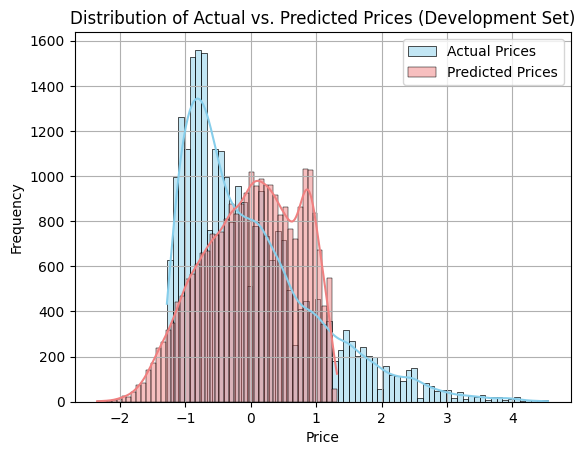

In [293]:
# Second Model: Multiple Linear Regression model to predict the price from numeric features odometer and years.

# Divide data into train, test, and dev sets
X = car_sales_2.drop('price', axis=1)
y = car_sales_2['price']

X = (X - X.mean()) / X.std()
y = (y - y.mean())/y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Select only 'odometer' and 'year' as features for this specific model
features = ['odometer', 'year']
X_train_numeric = X_train[features]
X_dev_numeric = X_dev[features]
X_test_numeric = X_test[features]

# Create and train the Linear Regression model
model_2 = LinearRegression(fit_intercept=True)
model_2.fit(X_train_numeric, y_train)

# Make predictions on the development set
y_pred_dev_numeric = model_2.predict(X_dev_numeric)

# Evaluate the model
mse_numeric = mean_squared_error(y_dev, y_pred_dev_numeric)
rmse_numeric = np.sqrt(mse_numeric)

print("Multiple Linear Regression Model Evaluation (Numeric Features: Odometer, Year):")
print(f"Mean Squared Error (MSE): {mse_numeric}")
print(f"Root Mean Squared Error (RMSE): {rmse_numeric}")

# Print model coefficients
print("\nModel Coefficients:")
print(f"Intercept: {model_2.intercept_}")
print(f"Odometer coefficient: {model_2.coef_[0]}")
print(f"Year coefficient: {model_2.coef_[1]}")

# Plot histogram of actual prices
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)

# Plot histogram of predicted prices
sns.histplot(y_pred_dev_numeric, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [297]:
# Use model_2 to predict the price for odometer and year

# Calculate the mean and standard deviation of 'odometer' and 'year' from the original car_sales
mean_odometer = car_sales_2['odometer'].mean()
std_odometer = car_sales_2['odometer'].std()
mean_year = car_sales_2['year'].mean()
std_year = car_sales_2['year'].std()

print(mean_odometer)
print(std_odometer)
print(mean_year)
print(std_year)

# Standardize the new data point

odometer = 5000
year = 2021
new_odometer_scaled = (odometer - mean_odometer) / std_odometer
new_year_scaled = (year - mean_year) / std_year

# Create a DataFrame for the new data point, ensuring column names match the training data
new_data = pd.DataFrame([[new_odometer_scaled, new_year_scaled]], columns=['odometer', 'year'])

# Use model_2 to predict the scaled price
predicted_price_scaled = model_2.predict(new_data)[0]

# We also need to unscale the predicted price.
# The target 'y' was standardized using (y - y.mean()) / y.std() from the original car_sales['price']
mean_price = car_sales_2['price'].mean()
std_price = car_sales_2['price'].std()

# Unscale the predicted price
predicted_price = (predicted_price_scaled * std_price) + mean_price

print(f"Predicted price is: ${predicted_price:.2f}")

95883.22711311106
56901.79411729085
2012.6613930921915
4.850016044743212
Predicted price is: $27594.99


In [298]:
car_sales_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133559 entries, 49 to 426878
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         133559 non-null  int64  
 1   odometer      133559 non-null  float64
 2   year          133559 non-null  float64
 3   title_status  133559 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 5.1+ MB


In [299]:
# Perform one hot encoding on car_sales_3 inplace for column title_status

import pandas as pd
car_sales_3 = pd.get_dummies(car_sales_3, columns=['title_status'], drop_first=True)
car_sales_3.info()
car_sales_3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 133559 entries, 49 to 426878
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    133559 non-null  int64  
 1   odometer                 133559 non-null  float64
 2   year                     133559 non-null  float64
 3   title_status_lien        133559 non-null  bool   
 4   title_status_missing     133559 non-null  bool   
 5   title_status_parts only  133559 non-null  bool   
 6   title_status_rebuilt     133559 non-null  bool   
 7   title_status_salvage     133559 non-null  bool   
dtypes: bool(5), float64(2), int64(1)
memory usage: 4.7 MB


,price,odometer,year,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage
49,32990,20581.0,2020.0,False,False,False,False,False
59,14000,95000.0,2012.0,False,False,False,False,False
73,15000,90000.0,2017.0,False,False,False,True,False
75,18590,28942.0,2018.0,False,False,False,False,False
76,29590,70760.0,2017.0,False,False,False,False,False


In [302]:
# Divide data into train, test, and dev sets
X = car_sales_3.drop('price', axis=1)
y = car_sales_3['price']

X = (X - X.mean()) / X.std()
y = (y - y.mean())/y.std()

# Split into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Split temp into validation (50% of temp, 20% of total) and test (50% of temp, 20% of total)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Multiple Linear Regression Model Evaluation (Features: Odometer, Year, Title Status):
Mean Squared Error (MSE): 0.4617003358501869
Root Mean Squared Error (RMSE): 0.6794853463101224

Model Coefficients:
Intercept: 7.352187358565087e-05
Odometer coefficient: -0.3476094016094755
Year coefficient: 0.4308428278035946
Title Status Coefficients:
title_status_lien: -0.0019665837303285017
title_status_missing: -0.007453645061978514
title_status_parts only: -0.00577646195586135
title_status_rebuilt: -0.08715369331935909
title_status_salvage: -0.05612507643734564


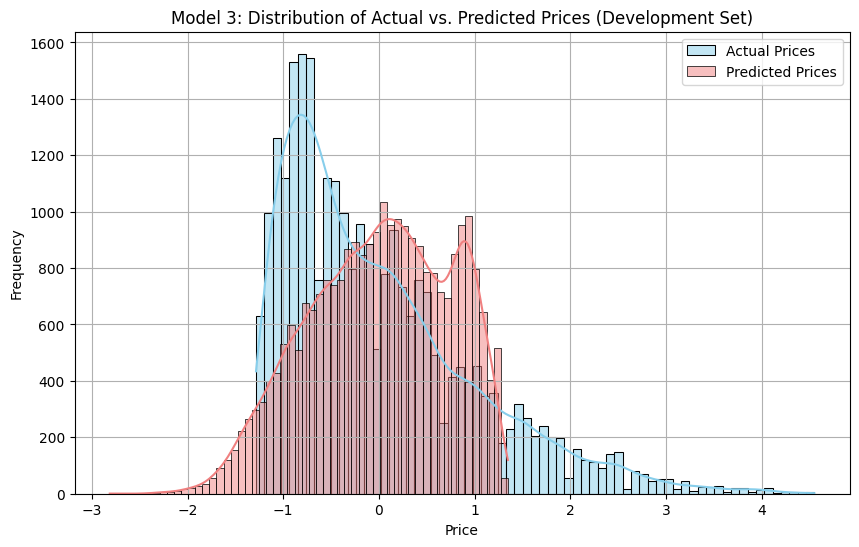

In [303]:
# Same as second model above, create a model_3 to predict price using dataset X which has odometer, year and title_status

# Select features and target
features = ['odometer', 'year'] + list(car_sales_3.columns[car_sales_3.columns.str.startswith('title_status_')])
target = 'price'

X_train_model3 = X_train[features]
X_dev_model3 = X_dev[features]
X_test_model3 = X_test[features]

# Create and train the Linear Regression model
model_3 = LinearRegression(fit_intercept=True)
model_3.fit(X_train_model3, y_train)

# Make predictions on the development set
y_pred_dev_model3 = model_3.predict(X_dev_model3)

# Evaluate the model
mse_model3 = mean_squared_error(y_dev, y_pred_dev_model3)
rmse_model3 = np.sqrt(mse_model3)

print("Multiple Linear Regression Model Evaluation (Features: Odometer, Year, Title Status):")
print(f"Mean Squared Error (MSE): {mse_model3}")
print(f"Root Mean Squared Error (RMSE): {rmse_model3}")

# Print model coefficients
print("\nModel Coefficients:")
print(f"Intercept: {model_3.intercept_}")
# Assuming the order of coefficients corresponds to the order of features
print(f"Odometer coefficient: {model_3.coef_[0]}")
print(f"Year coefficient: {model_3.coef_[1]}")
# Print coefficients for title status (adjust slicing based on the number of one-hot encoded columns)
title_status_cols = features[2:] # Features after odometer and year
print("Title Status Coefficients:")
for i, col in enumerate(title_status_cols):
    print(f"{col}: {model_3.coef_[2 + i]}")


# Plot histogram of actual vs predicted prices for model_3 on the development set
plt.figure(figsize=(10, 6))

# Plot histogram of actual prices
sns.histplot(y_dev, color='skyblue', label='Actual Prices', kde=True)

# Plot histogram of predicted prices
sns.histplot(y_pred_dev_model3, color='lightcoral', label='Predicted Prices', kde=True)

plt.title('Model 3: Distribution of Actual vs. Predicted Prices (Development Set)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [344]:
# Predict price of the car using model_3 with odometer, year , title_status

import pandas as pd
# Predict price using model_3 with the specified parameters

# Input parameters
odometer = 90000
year = 2007
title_status	= "salvage"
title_status_salvage = 1 # Or other possible values based on the one-hot encoded columns

# Use the mean and std from the original 'car_sales_3' dataframe before splitting and scaling
mean_odometer_m3 = car_sales_3['odometer'].mean()
std_odometer_m3 = car_sales_3['odometer'].std()
mean_year_m3 = car_sales_3['year'].mean()
std_year_m3 = car_sales_3['year'].std()

# Standardize the numeric features
new_odometer_scaled_m3 = (odometer - mean_odometer_m3) / std_odometer_m3
new_year_scaled_m3 = (year - mean_year_m3) / std_year_m3

# Create a dictionary for the new data point, including numeric and all possible one-hot encoded columns
# Initialize all one-hot encoded columns to 0, then set the correct one to 1
new_data_dict_m3 = {'odometer': new_odometer_scaled_m3, 'year': new_year_scaled_m3}

# Get the names of the one-hot encoded columns from the training data
one_hot_cols = [col for col in X_train_model3.columns if col.startswith('title_status_')]

# Initialize all one-hot encoded columns for the new data point to 0
for col in one_hot_cols:
    new_data_dict_m3[col] = 0

# Set the value for the specific title_status provided to 1
# Construct the column name that corresponds to the input title_status
title_status_col_name = f'title_status_{title_status}'

# Check if the specified title_status exists in the one-hot encoded columns
if title_status_col_name in one_hot_cols:
    new_data_dict_m3[title_status_col_name] = 1
else:
    print(f"Warning: '{title_status}' is not a recognized title_status from the training data.")
    # Handle cases where the input title_status is not seen in training (e.g., default to a common one or handle as unknown)
    # For now, we will proceed with the existing columns, effectively treating the unknown status as if none of the trained statuses apply.
    # This might require more sophisticated handling in a production scenario.

# Create a DataFrame from the dictionary, ensuring the column order matches the training data
new_data_m3 = pd.DataFrame([new_data_dict_m3])[X_train_model3.columns]

# Use model_3 to predict the scaled price
predicted_price_scaled_m3 = model_3.predict(new_data_m3)[0]

# Unscale the predicted price
# Use the mean and std of the original 'price' from car_sales_3
mean_price_m3 = car_sales_3['price'].mean()
std_price_m3 = car_sales_3['price'].std()

predicted_price_raw_m3 = (predicted_price_scaled_m3 * std_price_m3) + mean_price_m3

print(f"Predicted price for a car with Odometer {odometer}, Year {year}, and Title Status '{title_status}': ${predicted_price_raw_m3:.2f}")


Predicted price for a car with Odometer 90000, Year 2007, and Title Status 'salvage': $9575.47


In [346]:
# Create two dataframes from car_sales. 1) where transmission is manual 2) where transmission is automatic

# Create dataframes based on transmission type
car_sales_4_manual = car_sales[car_sales['transmission'] == 'manual'].copy()
car_sales_4_automatic = car_sales[car_sales['transmission'] == 'automatic'].copy()

car_sales_4_manual = car_sales_4_manual[['price', 'odometer', 'year', 'title_status', 'transmission']].copy()
car_sales_4_automatic = car_sales_4_automatic[['price', 'odometer', 'year', 'title_status', 'transmission']].copy()

print("Dataframe for manual transmission cars:")
print(car_sales_4_manual.head())
print("\nDataframe for automatic transmission cars:")
print(car_sales_4_automatic.head())

print(f"\nNumber of manual transmission cars: {len(car_sales_4_manual)}")
print(f"Number of automatic transmission cars: {len(car_sales_4_automatic)}")

Dataframe for manual transmission cars:
     price  odometer    year title_status transmission
270  13500   92000.0  2000.0        clean       manual
326   4100  130206.0  2010.0      rebuilt       manual
370   5950   72000.0  2007.0        clean       manual
684   4100  130206.0  2010.0      rebuilt       manual
746  37500    4230.0  2020.0        clean       manual

Dataframe for automatic transmission cars:
     price  odometer    year title_status transmission
59   14000   95000.0  2012.0        clean    automatic
73   15000   90000.0  2017.0      rebuilt    automatic
86    3000  176144.0  2004.0        clean    automatic
95    2100   97000.0  2006.0        clean    automatic
110   9500   30376.0  2003.0        clean    automatic

Number of manual transmission cars: 5502
Number of automatic transmission cars: 112897


In [327]:
# Perform one hot encoding on car_sales_4 inplace for columns transmission and title_status

car_sales_4 = car_sales_3.copy()

car_sales_4


car_sales_4.drop(car_sales_4[car_sales_4['transmission'] == 'other'].index, inplace=True)
car_sales_4 = pd.get_dummies(car_sales_4, columns=['transmission', 'title_status'], drop_first=True)

car_sales_4.info()
car_sales_4.head()


Unique transmission types:
['other' 'automatic' 'manual']
<class 'pandas.core.frame.DataFrame'>
Index: 118399 entries, 59 to 426874
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   price                    118399 non-null  int64  
 1   odometer                 118399 non-null  float64
 2   year                     118399 non-null  float64
 3   transmission_manual      118399 non-null  bool   
 4   title_status_lien        118399 non-null  bool   
 5   title_status_missing     118399 non-null  bool   
 6   title_status_parts only  118399 non-null  bool   
 7   title_status_rebuilt     118399 non-null  bool   
 8   title_status_salvage     118399 non-null  bool   
dtypes: bool(6), float64(2), int64(1)
memory usage: 4.3 MB


,price,odometer,year,transmission_manual,title_status_lien,title_status_missing,title_status_parts only,title_status_rebuilt,title_status_salvage
59,14000,95000.0,2012.0,False,False,False,False,False,False
73,15000,90000.0,2017.0,False,False,False,False,True,False
86,3000,176144.0,2004.0,False,False,False,False,False,False
95,2100,97000.0,2006.0,False,False,False,False,False,False
110,9500,30376.0,2003.0,False,False,False,False,False,False


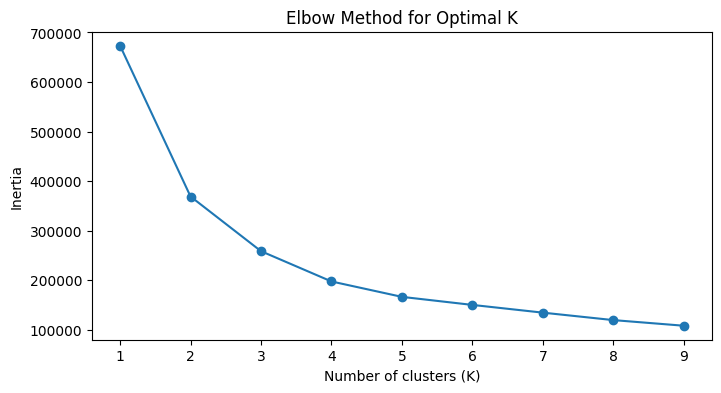

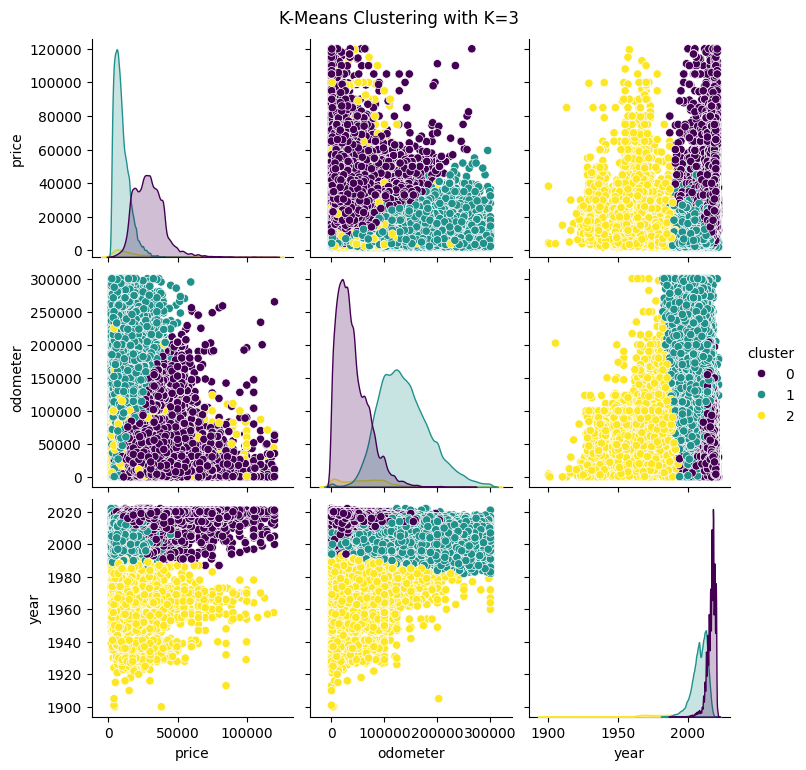

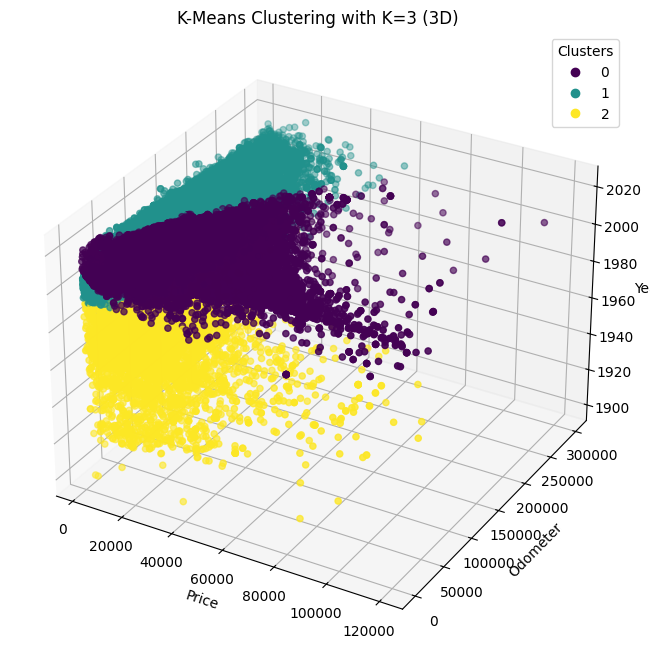


Cluster Means:
                price       odometer         year
cluster                                          
0        29286.516583   39250.560859  2016.396453
1         9421.928286  136666.953304  2008.281541
2        16428.879790   62100.965812  1970.720430

Cluster Counts:
cluster
0    104595
1    112559
2      7254
Name: count, dtype: int64

Distribution of Car Type in Cluster 0:
type
sedan     0.217764
pickup    0.170276
SUV       0.150323
other     0.111439
coupe     0.073139
Name: proportion, dtype: float64

Distribution of Car Type in Cluster 1:
type
sedan        0.258273
SUV          0.216793
not_given    0.173651
truck        0.090815
pickup       0.063487
Name: proportion, dtype: float64

Distribution of Car Type in Cluster 2:
type
not_given      0.247588
coupe          0.217397
convertible    0.126551
sedan          0.103667
truck          0.101461
Name: proportion, dtype: float64


In [91]:
# Create a k-means clustering model on car_sales dataframe and show the patterns with vizualization

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Select features for clustering (choose relevant numerical features)
features_for_clustering = ['price', 'odometer', 'year']
car_sales_clustering = car_sales[features_for_clustering].copy()

# Scale numerical features
scaler = StandardScaler()
car_sales_scaled = scaler.fit_transform(car_sales_clustering)

# Determine the optimal number of clusters (e.g., using the Elbow method)
inertia = []
K_range = range(1, 10)
for k in K_range:
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Set n_init explicitly
  kmeans.fit(car_sales_scaled)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Based on the Elbow method, let's choose a number of clusters (e.g., K=3 or K=4)
# Let's choose K=3 for this example
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Set n_init explicitly
car_sales_clustering['cluster'] = kmeans.fit_predict(car_sales_scaled)

# Visualize the clusters (using pairs of features)
# You can create scatter plots for different combinations of features colored by cluster
sns.pairplot(car_sales_clustering, vars=features_for_clustering, hue='cluster', palette='viridis')
plt.suptitle(f'K-Means Clustering with K={optimal_k}', y=1.02)
plt.show()

# You can also visualize the clusters using other plots, e.g., 3D scatter plot if you have 3 features
if len(features_for_clustering) == 3:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(car_sales_clustering['price'], car_sales_clustering['odometer'], car_sales_clustering['year'], c=car_sales_clustering['cluster'], cmap='viridis')
    ax.set_xlabel('Price')
    ax.set_ylabel('Odometer')
    ax.set_zlabel('Year')
    ax.set_title(f'K-Means Clustering with K={optimal_k} (3D)')
    legend = ax.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()

# Analyze the characteristics of each cluster
cluster_means = car_sales_clustering.groupby('cluster')[features_for_clustering].mean()
print("\nCluster Means:")
print(cluster_means)

# Count the number of cars in each cluster
cluster_counts = car_sales_clustering['cluster'].value_counts().sort_index()
print("\nCluster Counts:")
print(cluster_counts)

# You can further analyze the clusters by looking at the distribution of other categorical features within each cluster
# For example, the distribution of car 'type' within each cluster
for cluster_id in sorted(car_sales_clustering['cluster'].unique()):
    print(f"\nDistribution of Car Type in Cluster {cluster_id}:")
    print(car_sales[car_sales_clustering['cluster'] == cluster_id]['type'].value_counts(normalize=True).head())

# Similarly, you can explore other features like 'manufacturer', 'fuel', 'transmission', etc.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.